### Case Study: Credit Underwriting and Analysis

A credit company acquires applicants for credit. These applicants apply for credit, and the company decides whether to issue credit.

Using historical data, the business wants to build model that can predict whether an applicant will default, and understand which applicant characteristics drive loan performance.

### Goals:

* Build a predictive classifier. Defaults are both rare and expensive, we prefer a model that has a high recall on the default class.
* Be able to explain why an applicant was approved or denied, in the event that they ask for clarification.
* Uncover which types of applicants the firm should market to.

### Load the data

In [1]:
#!sudo pip install keras
#!sudo pip install tpot
%matplotlib inline
import pandas as pd
import numpy as np

df = pd.read_csv('LoanStats3a.csv', skiprows=1)
df = df[df.loan_status.isin(['Fully Paid','Charged Off'])]

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Utilities

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import label_binarize

def def_rates_by_categorical(column, with_variance=False, sort=True):
    grouped = df.groupby([column,'loan_status'])
    def_counts = grouped['loan_amnt'].count().unstack()
    N = def_counts.sum(axis=1)
    props = def_counts['Charged Off'] / N
    if sort:
        props = props.sort_values()
    var = ((props * (1 - props)) / N) ** (.5)
    if with_variance:
        ax = props.plot(kind = 'bar', yerr = var)
    else:
        ax = props.plot(kind = 'bar')
    ax.set_ylabel("Default Rate (0-1)")
    ax.set_title("Default Rates by {}".format(column))
    ax.set_xlabel(column)
    return ax
    
def round_to_nearest(x, base=1):
    return base * int(x / base)

def plot_roc_curve(y_test, X_test, model_dict):
    y_test_ = label_binarize(y_test, classes=[0, 1, 2])[:, :2]
    preds = {}
    fpr = {}
    tpr = {}
    roc_auc = {}
    f, ax = plt.subplots(1)
    
    #plt.figure()
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    
    plot_data = {}
    
    for model_key in model_dict:
        preds = model_dict[model_key].predict_proba(X_test)
        fpr = {}
        tpr = {} 
        roc_auc = {}        
        
        for i in range(2):
            fpr[i], tpr[i], _ = roc_curve(y_test_[:, i], preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_.ravel(), preds.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        name = "%s: (AUC = %0.2f)" % (model_key, roc_auc[1])
        plot_data = pd.DataFrame(tpr[1], index=fpr[1], columns = [name])
        plot_data.plot(ax=ax)
    plt.show()
    return ax


def classifaction_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = re.split('[ ]+', line)
        row['class'] = row_data[1]
        row['precision'] = float(row_data[2])
        row['recall'] = float(row_data[3])
        row['f1_score'] = float(row_data[4])
        row['support'] = float(row_data[5])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return dataframe



### Preprocessing

In [3]:
re_not_decimal = re.compile(r'[^\.0-9]*')

def process_int_rate(x):
    x = x.strip()
    x = re_not_decimal.sub("", x)    
    return float(x)

def process_revol_util(x):
    if pd.isnull(x):
        return 0
    else:
        x = x.strip()
        x = re_not_decimal.sub("", x)    
        return float(x)

def process_term(x):
    x = re_not_decimal.sub("", x)
    return int(x)

def process_emp_length(x):
    x = re_not_decimal.sub("", x)
    if x == '':
        return np.nan
    else:
        return float(x)
    


df['int_rate'] = df['int_rate'].apply(process_int_rate)
df['term'] = df['term'].apply(process_term)
df['emp_length'] = df['emp_length'].apply(process_emp_length)
df['revol_util'] = df['revol_util'].apply(process_revol_util)

### Distribution of credit outcomes

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


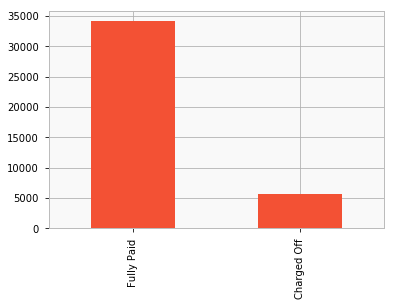

In [4]:
%matplotlib inline
df.loan_status.value_counts().plot(kind='bar')

### Lower grade credit related to default rates

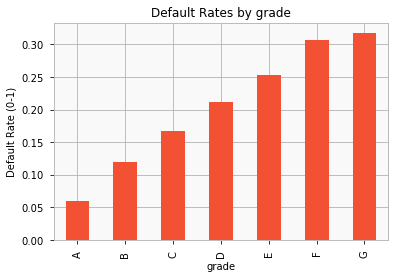

In [5]:
def_rates_by_categorical('grade')

### DTI also a factor

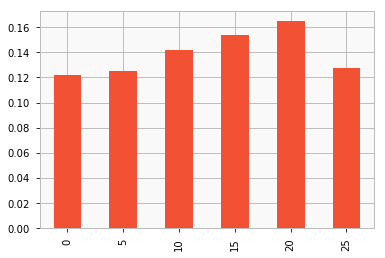

In [6]:
def_by_dti = df.set_index('dti').groupby(by=(lambda x: round_to_nearest(x, 5), 'loan_status'))['loan_amnt'].count().unstack()
def_by_dti = (def_by_dti['Charged Off'] / def_by_dti.sum(axis=1))
ax = def_by_dti.plot(kind = 'bar')

### Not what we'd expect from verification status

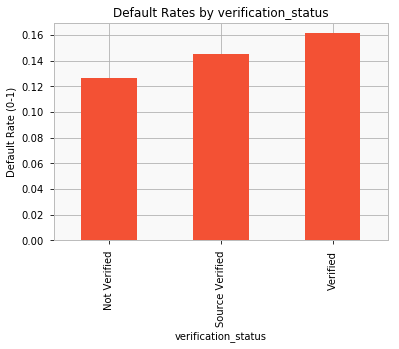

In [7]:
ax = def_rates_by_categorical('verification_status')

### Small business loans are much riskier

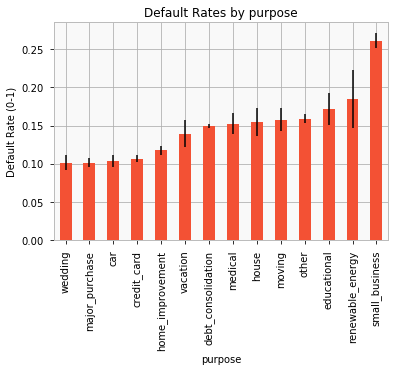

In [8]:
def_rates_by_categorical('purpose', with_variance=True)

### (Light) Feature Engineering

In [9]:
df_ = df.copy()

domain_columns = ['loan_amnt', 
                  'term', 
                  'annual_inc', 
                  'installment_over_income', 
                  'has_employer_info',
                  'is_employed',
                  'dti',
                  'purpose_is_small_business',
                  'inq_last_6mths',
                  'delinq_2yrs',
                  'open_acc',
                  'int_rate',
                  'revol_util'
                 ]

#features to engineer
df_['requested_minus_funded'] = df_['loan_amnt'] - df_['funded_amnt']
df_['has_employer_info'] = df_['emp_title'].isnull()
df_['installment_over_income'] = df_['installment'] / df_['annual_inc']
df_['is_employed'] = df_['emp_length'].isnull()



#dummy section
dummy_columns = ['home_ownership','purpose', 'grade', 'addr_state']

for column in dummy_columns:
    dummies = pd.get_dummies(df_[column], prefix="{}_is".format(column))
    columns_to_add = dummies.columns.values[:-1]
    dummies = dummies[columns_to_add]
    df_ = df_.join(dummies)
    domain_columns.extend(columns_to_add)

df_['default'] = df_['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

### Train/Test Split

In [10]:
from sklearn.model_selection import train_test_split

X = df_[domain_columns].values
y = df_['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)

### Train a Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()
reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Train a Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Train a feed forward NN

In [13]:
os.environ['KERAS_BACKEND'] = 'theano'
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def create_nn():
    # create model
    model = Sequential()
    model.add(Dense(X.shape[1], input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_nn, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)

Using Theano backend.
/usr/local/lib/python2.7/dist-packages/scikit_learn-0.18.1-py2.7-linux-x86_64.egg/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe937dcec50>)])

In [14]:
from sklearn.ensemble import VotingClassifier
ensemble_soft = VotingClassifier([('rf',rf), ('regression', reg), ('neural_network',pipeline)], voting='soft')
ensemble_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_...with_std=True)), ('mlp', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe937dcec50>)]))],
         n_jobs=1, voting='soft', weights=None)

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


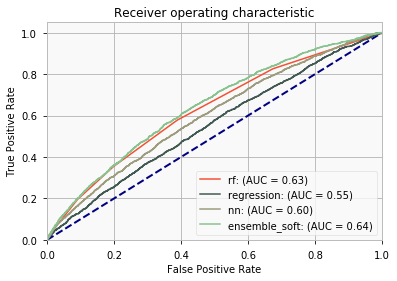

In [15]:
models = {'regression':reg,
          'nn':pipeline,
          'rf':rf,
          'ensemble_soft':ensemble_soft}
ax = plot_roc_curve(y_test, X_test, models)

In [16]:
from sklearn.metrics import classification_report
reports = []
for model_key in models:
    
    test_preds = models[model_key].predict(X_test)
    report = classifaction_report_csv(classification_report(y_test, test_preds))
    report['model'] = model_key
    #report.index = [model_key] * 2
    report = report.set_index(['model','class'])
    reports.append(report)

reports = pd.concat(reports)
reports[['precision','recall']]

/usr/local/lib/python2.7/dist-packages/scikit_learn-0.18.1-py2.7-linux-x86_64.egg/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision  recall
model         class                   
rf            0           0.87    0.99
              1           0.34    0.04
regression    0           0.86    1.00
              1           0.00    0.00
nn            0           0.87    0.91
              1           0.23    0.16
ensemble_soft 0           0.87    0.99
              1           0.33    0.03

### Given the recall on default class, NN is our pick

Lets use skater to explore our model

In [17]:
from skater import Interpretation
from skater.model import InMemoryModel

model_nn = InMemoryModel(pipeline.predict_proba, target_names=['Paid off',' Default'], examples=X_train[:5])

interpreter = Interpretation(X_train, feature_names=domain_columns)


### Feature importance (top 20)

In [18]:
importances = interpreter.feature_importance.feature_importance(model_nn)

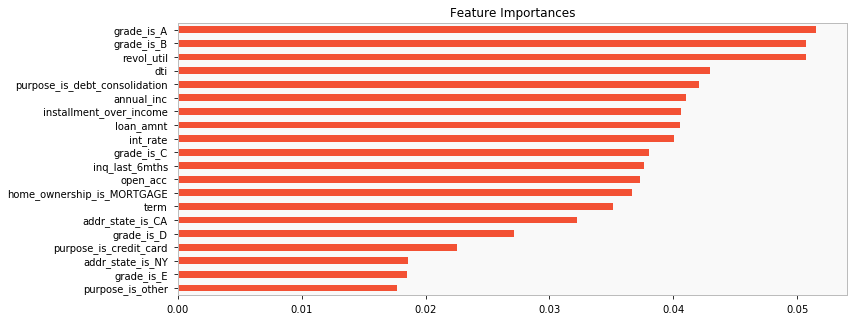

In [19]:
ax = importances.iloc[-20:].plot(kind='barh', figsize = (12, 5))
ax.grid()
title = ax.set_title('Feature Importances')

### Evaluate the relationship between top features and default risk:

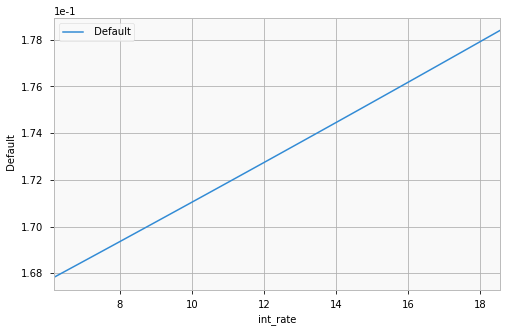

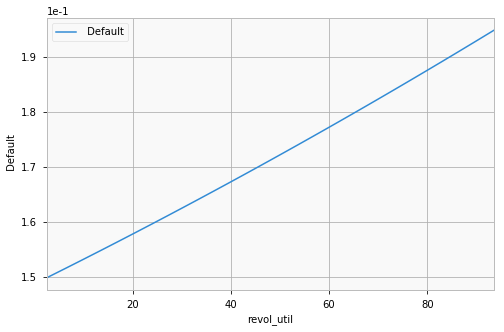

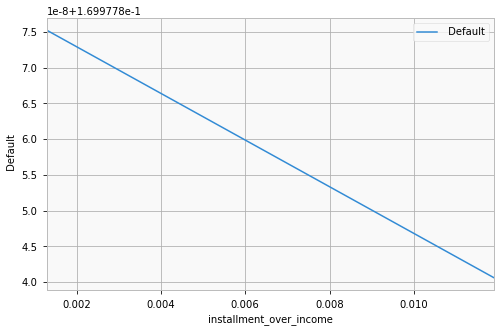

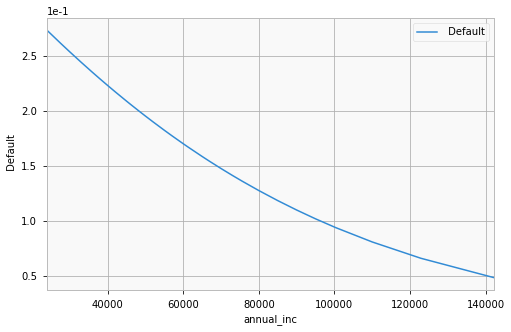

In [15]:
plots = interpreter.partial_dependence.plot_partial_dependence(['int_rate',
                                                        'revol_util',
                                                        'installment_over_income',
                                                        'annual_inc'], 
                                                       model_nn, 
                                                       n_samples=500,
                                                       figsize=(8, 5))

### Most of the key relationships are linear

In [234]:
%matplotlib notebook

[[<matplotlib.figure.Figure at 0x7fe93824b1d0>,

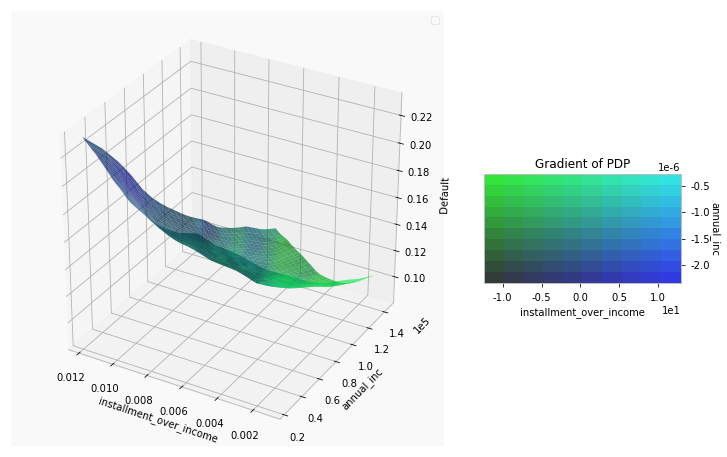

In [21]:
interpreter.partial_dependence.plot_partial_dependence([('installment_over_income','annual_inc')], 
                                                       model_nn, 
                                                       n_samples=500,
                                                       figsize = (12, 8))

[[<matplotlib.figure.Figure at 0x7fe90d8b3d90>,

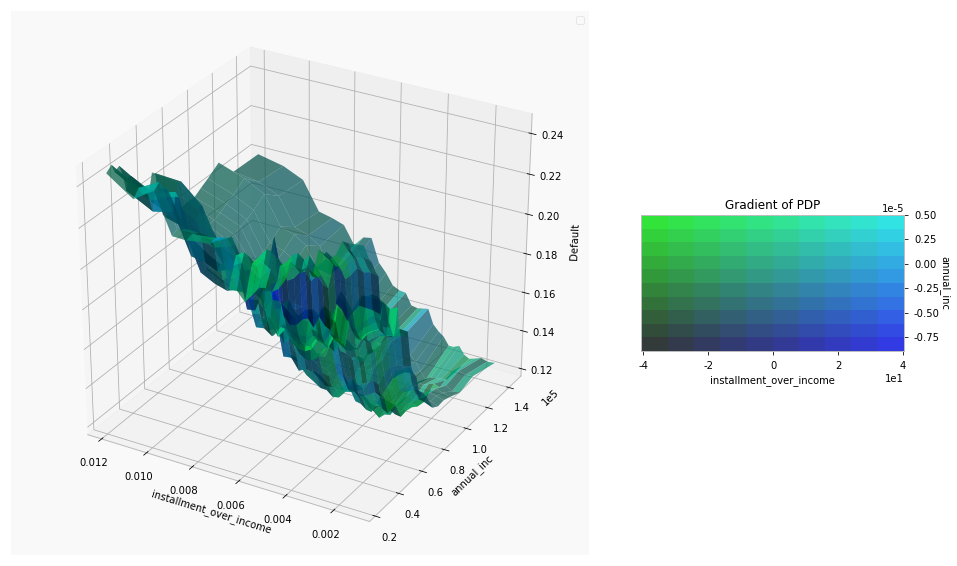

In [22]:
model_rf = InMemoryModel(rf.predict_proba, target_names=['Paid off',' Default'], examples=X_train[:5])
interpreter.partial_dependence.plot_partial_dependence([('installment_over_income','annual_inc')], 
                                                       model_rf, 
                                                       n_samples=500)